[*********************100%%**********************]  34 of 34 completed


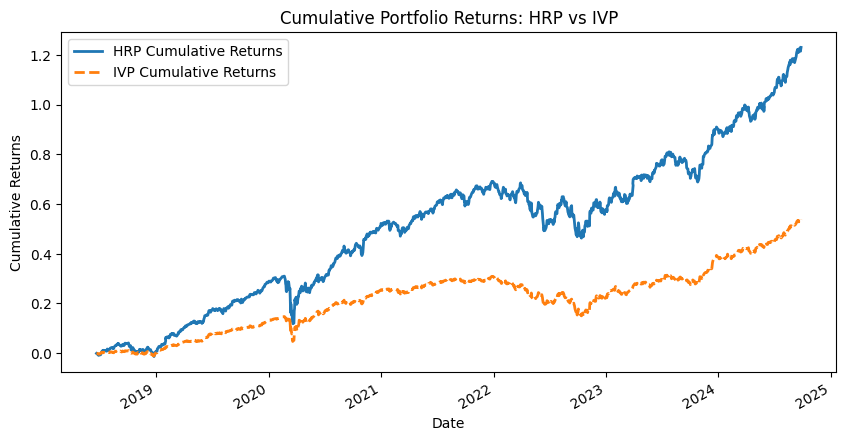


IVP Portfolio Statistics:
Annualized Return: 0.06
Annualized Volatility: 0.02
Sharpe Ratio: 3.14
Max Drawdown: 0.03


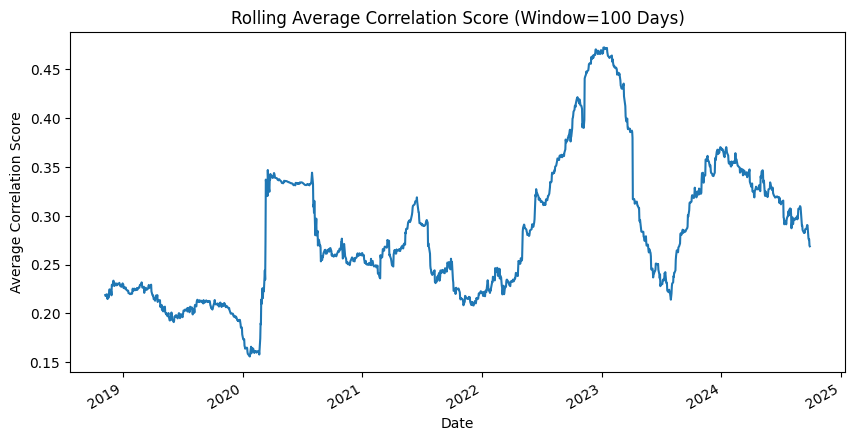

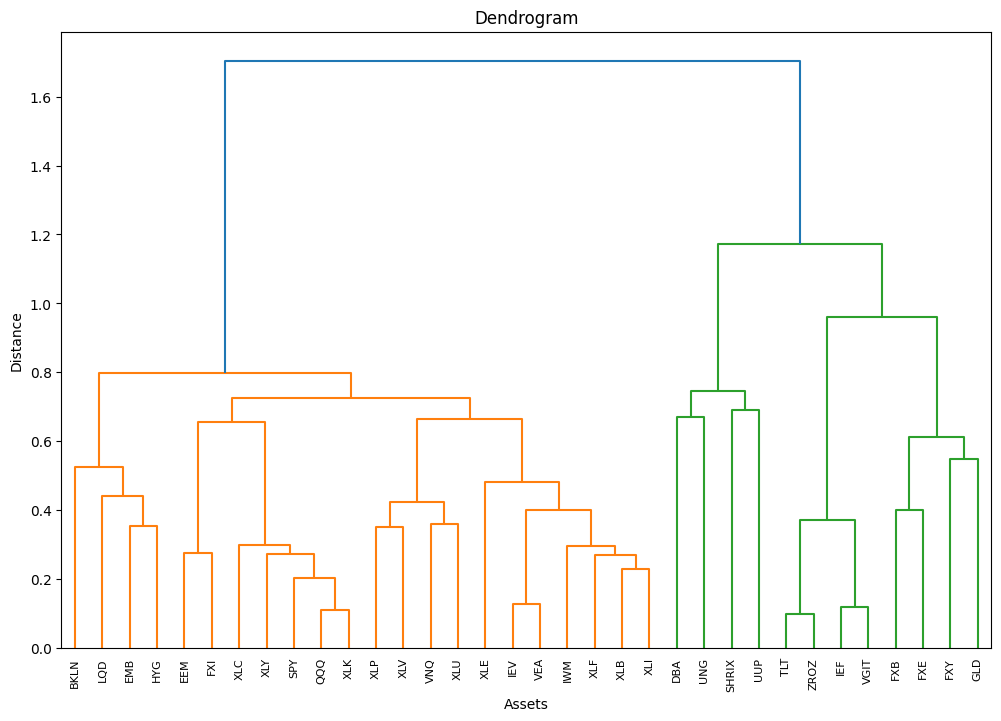

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import yfinance as yf
import scipy.cluster.hierarchy as sch
from scipy.optimize import minimize
import warnings

# Suppress specific FutureWarnings and general warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='yfinance')
warnings.filterwarnings("ignore", category=UserWarning)

# Define the tickers
tickers = [
    'XLU', 'VNQ', 'QQQ', 'XLK', 'XLP', 'XLC', 'XLY', 'SPY', 'XLI', 'XLV',
    'IWM', 'XLF', 'XLB', 'XLE', 'VEA', 'IEV', 'EEM', 'FXI', 'UUP',
    'FXY', 'FXB', 'FXE', 'GLD', 'DBA', 'UNG', 'IEF', 'LQD', 'EMB',
    'HYG', 'VGIT', 'BKLN', 'SHRIX', 'TLT', 'ZROZ'
]

# Download data from Yahoo Finance
def download_data(tickers):
    attempts = 5
    for _ in range(attempts):
        try:
            data = yf.download(tickers, start="2018-01-01", end=pd.to_datetime("today").strftime('%Y-%m-%d'))
            return data
        except Exception as e:
            print(f"Download attempt failed: {e}")
    raise ConnectionError("Failed to download data after multiple attempts")

# Fetch dividend data for tickers
def fetch_dividends(tickers):
    dividends = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        dividends[ticker] = stock.dividends
    return dividends

# Adjust returns for dividends
def adjust_returns_for_dividends(prices, dividends, tickers):
    adjusted_returns = prices.pct_change().dropna()
    
    # Ensure both prices and dividends have timezone-naive datetime indices
    prices.index = prices.index.tz_localize(None)
    for ticker in dividends:
        dividends[ticker].index = pd.to_datetime(dividends[ticker].index).tz_localize(None)
    
    for ticker in tickers:
        dividend_yield = dividends[ticker] / prices[ticker].shift(1)
        adjusted_returns[ticker] += dividend_yield.fillna(0)
    
    adjusted_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
    return adjusted_returns.dropna()

# Hierarchical Risk Parity functions
def correlDist(corr):
    dist = ((1 - corr) / 2.)**.5
    return dist

def getQuasiDiag(link):
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)
        df0 = sortIx[sortIx >= numItems]
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = list(sortIx)
        sortIx.extend(df0.tolist())
        sortIx = pd.Series(sortIx).sort_index()
        sortIx.index = range(sortIx.shape[0])
    return sortIx.tolist()

def getClusterVar(cov, cItems, max_weight=0.075):
    cov_ = cov.loc[cItems, cItems]
    w_ = getIVP(cov_).reshape(-1, 1)
    w_ = np.minimum(w_, max_weight)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar

def getRecBipart(cov, sortIx, max_weight=0.075):
    w = pd.Series(1.0, index=sortIx, dtype=float)
    cItems = [sortIx]
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]
        for i in range(0, len(cItems), 2):
            cItems0 = cItems[i]
            cItems1 = cItems[i + 1]
            cVar0 = getClusterVar(cov, cItems0, max_weight)
            cVar1 = getClusterVar(cov, cItems1, max_weight)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha
            w[cItems1] *= 1 - alpha
    return w

def getHRP(cov, corr, max_weight=0.075):
    dist = correlDist(corr)
    condensed_dist = sch.distance.squareform(dist, checks=False)
    link = sch.linkage(condensed_dist, 'ward')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx, max_weight)
    return hrp.sort_index()

def getIVP(cov):
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def apply_shrinkage(cov):
    lw = LedoitWolf()
    lw_cov = lw.fit(cov).covariance_
    return pd.DataFrame(lw_cov, index=cov.index, columns=cov.columns)

# Portfolio allocation logic with category weights
def calculate_portfolio_returns(returns, allocation_percentages, category_ranges, max_weight=0.075):
    months = returns.index.to_period('M').unique()
    portfolio_weights = {}
    category_portfolios = {}

    for month in months:
        last_day_of_month = returns[returns.index.to_period('M') == month].index.max()
        monthly_returns_data = returns.loc[last_day_of_month - pd.Timedelta(days=29):last_day_of_month]

        for category, category_range in category_ranges.items():
            category_returns = monthly_returns_data.iloc[:, category_range]
            cov = category_returns.cov()
            corr = category_returns.corr()
            cov = apply_shrinkage(cov)
            hrp = getHRP(cov, corr, max_weight)
            portfolio_weights[category] = hrp * allocation_percentages[category]
            month_returns = category_returns.dot(portfolio_weights[category])
            if category not in category_portfolios:
                category_portfolios[category] = month_returns
            else:
                category_portfolios[category] = pd.concat([category_portfolios[category], month_returns])

    total_portfolio_returns = pd.DataFrame(category_portfolios).sum(axis=1)
    return total_portfolio_returns

def get_IVP_returns(adjusted_returns):
    cov_matrix = adjusted_returns.cov()
    ivp_weights = getIVP(cov_matrix)
    ivp_returns = adjusted_returns.dot(ivp_weights)
    return ivp_returns


# Plot cumulative returns for HRP vs IVP
def plot_cumulative_returns(hrp_returns, ivp_returns):
    hrp_cum_returns = (1 + hrp_returns).cumprod() - 1
    ivp_cum_returns = (1 + ivp_returns).cumprod() - 1
    plt.figure(figsize=(10, 5))
    hrp_cum_returns.plot(label='HRP Cumulative Returns', linewidth=2)
    ivp_cum_returns.plot(label='IVP Cumulative Returns', linestyle='--', linewidth=2)
    plt.title("Cumulative Portfolio Returns: HRP vs IVP")
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    data = download_data(tickers)
    prices = data['Adj Close']
    dividends = fetch_dividends(tickers)
    
    # Adjust returns for dividends
    adjusted_returns = adjust_returns_for_dividends(prices, dividends, tickers)

    # Calculate HRP portfolio returns
    category_ranges = {
        'US_equities': slice(0, 14),
        'Int_equities': slice(14, 18),
        'currencies': slice(18, 22),
        'commodities': slice(22, 25),
        'fixed_income': slice(25, 29),
        'fixed_income2': slice(29, 32),
        'fixed_income3': slice(32, 34)
    }
    allocation_percentages = {
        'US_equities': 0.35,
        'Int_equities': 0.10,
        'currencies': 0.05,
        'commodities': 0.05,
        'fixed_income': 0.15,
        'fixed_income2': 0.15,
        'fixed_income3': 0.15
    }
    
    hrp_returns = calculate_portfolio_returns(adjusted_returns, allocation_percentages, category_ranges)

    # Get IVP portfolio returns
    ivp_returns = get_IVP_returns(adjusted_returns)

    # Plot HRP vs IVP cumulative returns
    plot_cumulative_returns(hrp_returns, ivp_returns)
    
    # Calculate trading statistics for MVO portfolio
    mvo_ann_return, mvo_ann_volatility, mvo_sharpe_ratio, mvo_max_drawdown = trading_statistics(mvo_portfolio_returns)

    # Print trading statistics for MVO portfolio
    print(f"\nIVP Portfolio Statistics:")
    print(f"Annualized Return: {mvo_ann_return:.2f}")
    print(f"Annualized Volatility: {mvo_ann_volatility:.2f}")
    print(f"Sharpe Ratio: {mvo_sharpe_ratio:.2f}")
    print(f"Max Drawdown: {mvo_max_drawdown:.2f}")

    # Calculate the rolling correlation score
    rolling_corr_score = calculate_rolling_correlation_score(adjusted_returns, window_size=100)

    # Plot rolling correlation score
    plt.figure(figsize=(10, 5))
    rolling_corr_score.plot()
    plt.title("Rolling Average Correlation Score (Window=100 Days)")
    plt.ylabel('Average Correlation Score')
    plt.xlabel('Date')
    plt.show()
    # Calculate the correlation matrix
    corr_matrix = adjusted_returns.corr()
    corr_matrix
    # Plot the dendrogram
    plot_dendrogram(corr_matrix)
